In [102]:
# 1. Create jsonl file with requests for batch completion

import json
import tiktoken
import os
from generate_stories import create_simple_story_prompt, iterate_params

MODEL_PARAMETERS = {"top_p": 0.9}

def get_batch_dataset(num_completions, model, offset=0):
    
    enc = tiktoken.encoding_for_model(model)
    params_iterator = iterate_params()
    for _ in range(offset):
        next(params_iterator)
    
    while True:
        lines = []
        total_tokens = 0
        for i in range(num_completions):
            params = next(params_iterator)
            prompt, num_stories_in_completion = create_simple_story_prompt(params.copy())
            message_tokens = len(enc.encode(prompt))
            total_tokens += message_tokens
            messages=[{"role": "user", "content": prompt}]

            lines.append(json.dumps(
                {"custom_id": str(i)+json.dumps(params | {"expected_num_stories_in_completion": num_stories_in_completion} | MODEL_PARAMETERS, ensure_ascii=False),
                "method": "POST",
                "url": "/v1/chat/completions",
                "body": {"model": model, "messages": messages, **MODEL_PARAMETERS}},
                  ensure_ascii=False
                ))
        
        print(f"Total input tokens: {total_tokens}")

        yield lines

def write_batch_completion_file(num_completions, model, base_filename, offset=0):
    iterator = get_batch_dataset(num_completions, model, offset)
    counter = 1
    filename = base_filename
    while True:
        lines = next(iterator)
        filename = f"{base_filename}_{str(counter)}.jsonl"
        with open(filename, "w", encoding="utf-8") as fp:
            fp.write("\n".join(lines))
        counter += 1
        yield filename
    
if not os.path.exists("data"):
    os.makedirs("data")

In [103]:
# 2. Execute Batch Jobs

import os
import time
from datetime import datetime
from openai import OpenAI
from tqdm import tqdm
        
NUM_COMPLETIONS = 50_000
NUM_COMPLETIONS_PER_REQUEST = 50_000 # Calculate this based on rate limits, to be checked at https://platform.openai.com/settings/organization/limits
OFFSET =  290_000
MODEL = "gpt-4o-mini"
MAX_RETRIES = 3

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

def check_batch_status(batch_id, batch_number, directory):
    while True:
        batch_status = client.batches.retrieve(batch_id)

        status = batch_status.status
        print(f"Batch status: {status}")

        if status == "validating":
            print("The input file is being validated. Please wait...")
        elif status == "failed":
            print("The input file has failed validation.")
            return False
        elif status == "in_progress":
            print("The batch is currently being processed. Please wait...")
        elif status == "finalizing":
            print("The batch is completed and the results are being prepared.")
        elif status == "completed":
            print("The batch is complete, downloading the results...")
            download_batch_results(batch_status.output_file_id, batch_number, directory)
            return True
        elif status == "expired":
            print("The batch was not completed within the 24-hour time window.")
            return False
        elif status == "cancelling":
            print("The batch is being cancelled. Please wait...")
        elif status == "cancelled":
            print("The batch was cancelled.")
            return False
        else:
            print("Unknown status encountered.")

        time.sleep(30)  # Wait for 30 seconds before checking the status again
        
def download_batch_results(output_file_id, batch_number, directory):
    with open(os.path.join(directory, "output_file_ids.txt"), "a", encoding="utf-8") as f:
        f.write(output_file_id + "\n")

    file_response = client.files.content(output_file_id)
    filename = f"{directory}/batch_data_{batch_number}.jsonl"
    
    # Process each JSON line to output actual UTF-8 characters instead of unicode escapes.
    processed_lines = []
    for line in file_response.text.splitlines():
        if line.strip():
            data = json.loads(line)
            processed_lines.append(json.dumps(data, ensure_ascii=False))
    
    with open(filename, 'w', encoding="utf-8") as f:
        f.write("\n".join(processed_lines))

In [ ]:
total_completions = 0
batch_number = 0
consecutive_failures = 0

directory = os.path.join("data", f"batches_{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}")
os.makedirs(directory, exist_ok=True)
os.makedirs(os.path.join(directory, "prompts"), exist_ok=True)

base_filename = os.path.join(directory, "prompts", "batch")
batch_writer_iter = write_batch_completion_file(NUM_COMPLETIONS_PER_REQUEST, MODEL, base_filename, offset=OFFSET)
with tqdm(total=NUM_COMPLETIONS, desc="Batch Generation") as pbar:
    while total_completions < NUM_COMPLETIONS and consecutive_failures < MAX_RETRIES:
        try:
            # 1. Write the batch completion file
            batch_number += 1
            filename = next(batch_writer_iter)

            # 2. Upload the batch file
            batch_input_file = client.files.create(
                file=open(filename, "rb"),
                purpose="batch"
            )
            batch_input_file_id = batch_input_file.id
            with open(os.path.join(directory, "input_file_ids.txt"), "a", encoding="utf-8") as f:
                f.write(batch_input_file_id + "\n")

            # 3. Create the batch job
            batch_info = client.batches.create(
                input_file_id=batch_input_file_id,
                endpoint="/v1/chat/completions",
                completion_window="24h",
                metadata={
                    "description": f"Simple Stories Story Generation - batch {batch_number}, n={NUM_COMPLETIONS_PER_REQUEST}"
                }
            )

            batch_id = batch_info.id
            with open(os.path.join(directory, "batch_job_ids.txt"), "a", encoding="utf-8") as f:
                f.write(batch_id + "\n")

            # 4. Check the status and download the results
            if check_batch_status(batch_id, batch_number, directory):
                total_completions += NUM_COMPLETIONS_PER_REQUEST
                pbar.update(NUM_COMPLETIONS_PER_REQUEST)
                consecutive_failures = 0
            else:
                consecutive_failures += 1

        except Exception as e:
            print(f"An error occurred: {e}")
            consecutive_failures += 1

    if consecutive_failures >= MAX_RETRIES:
        print(f"Stopping due to {MAX_RETRIES} consecutive failures.")

In [2]:
# In case something went wrong, we can download the result from the last requested batch like this:
BATCH_NUMBER = 2
BATCH_ID = "file-Xgdr1LxAYZU3dARzVSaqaG"
DIRECTORY = "batches_2025-02-01-23-00-13"

#client.batches.list(limit=1)
# download_batch_results(BATCH_ID, BATCH_NUMBER, DIRECTORY)

In [4]:
# 3. Format batch output
import re
import json
import os
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from textstat import flesch_reading_ease, flesch_kincaid_grade, dale_chall_readability_score
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import List, Dict

from generate_stories import process_completion

nltk.download('punkt_tab', quiet=True)

def nlp_metrics(s: str) -> dict:
    # Tokenize words and sentences
    words = word_tokenize(s)
    sentences = sent_tokenize(s)
    
    word_count = len(words)
    character_count = len(s)
    
    avg_word_length = np.mean([len(word) for word in words]) if word_count > 0 else 0
    avg_sentence_length = word_count / len(sentences) if sentences else 0
    
    flesch_reading = flesch_reading_ease(s)
    flesch_kincaid = flesch_kincaid_grade(s)
    dale_chall = dale_chall_readability_score(s)
    
    return {
        "word_count": word_count,
        "character_count": character_count,
        "avg_word_length": round(avg_word_length, 2),
        "avg_sentence_length": round(avg_sentence_length, 2),
        "flesch_reading_ease": flesch_reading,
        "flesch_kincaid_grade": flesch_kincaid,
        "dale_chall_readability_score": dale_chall
    }

def process_batch(batch: List[str]) -> List[Dict]:
    results = []
    for line in batch:
        data = json.loads(line)
        
        custom_id = data['custom_id']
        match = re.search(r'{.*}', custom_id)
        if not match:
            continue
            
        params = json.loads(match.group(0))
        completion = data['response']['body']['choices'][0]['message']['content']
        gen_model = data['response']['body']['model']
        
        json_struct = process_completion(gen_model, completion, params, 
                                      expected_num_stories=params.get("expected_num_in_stories", None))
        story_dicts = [item for item in json_struct if 'story' in item]
        
        for story_dict in story_dicts:
            story_dict.update(nlp_metrics(story_dict['story']))
            results.append(story_dict)
            
    return results

def format_jsonl(input_files, output_file, batch_size=1000, max_workers=8):
    assert not os.path.isfile(output_file), "output file already exists"
    
    def process_file(input_file):
        with open(input_file, 'r', encoding="utf-8") as f:
            batch = []
            for line in f:
                batch.append(line)
                if len(batch) >= batch_size:
                    yield batch
                    batch = []
            if batch:  # Process remaining lines
                yield batch
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        with open(output_file, 'a', encoding="utf-8") as outfile:
            for input_file in input_files:
                futures = []
                for batch in process_file(input_file):
                    future = executor.submit(process_batch, batch)
                    futures.append(future)
                    
                    # Write completed results to keep memory usage low
                    for completed in as_completed(futures):
                        results = completed.result()
                        for result in results:
                            outfile.write(json.dumps(result) + '\n')
                        futures.remove(completed)

input_dir =  os.path.join('data', DIRECTORY)
input_files = []
input_files.extend([os.path.join(input_dir,file) for file in os.listdir(input_dir) if file.endswith('.jsonl') and os.path.isfile(os.path.join(input_dir, file))])
output_file = os.path.join(input_dir, 'processed.jsonl')

format_jsonl(input_files, output_file)

In [3]:
# 3.1: Postprocessing
import pandas as pd
import os

input_dir = os.path.join('data', DIRECTORY)
output_file = os.path.join(input_dir, 'processed.jsonl')
parquet_file_path = output_file.replace(".jsonl", ".parquet")

df = pd.read_json(output_file, lines=True)
#df = df.sample(frac=1).reset_index(drop=True)
#df.to_parquet(parquet_file_path, engine='pyarrow', compression='snappy')
#df.to_json(output_file, orient='records', lines=True)

# TODO: Maybe filter out excessively long completions, such as when the end string was not correctly generated. Also, check for non-Latin characters.

In [83]:
df = pd.read_csv('updated_file.csv')

In [ ]:
# Remove excessively short and long completions, these tend not to have followed the prompt
LANGUAGE = "JA"
if LANGUAGE == "EN":
    # We remove non-Latin characters
    from unidecode import unidecode
    df['story'] = df['story'].apply(lambda x: unidecode(x))

    df = df[df["word_count"] > 50]
    long = df[df["word_count"] > 500]
    long = long[long['num_stories_in_completion'] < long['expected_num_stories_in_completion'] - 1]
    df = df[~df.isin(long.to_dict(orient='list')).all(axis=1)]
    df = df[df["word_count"] < 800]
    
    # The word type column name might look awkward out of context, so we remove the article
    df["initial_word_type"] = df["initial_word_type"].apply(lambda x: x.split()[1])
elif LANGUAGE == "JA":
    df = df[df["character_count"] < 1000]
    df = df[df["character_count"] > 50]

    # Sometimes the model fill output 「終わり」instead of 終わり. We remove the outer quotes.
    def remove_outer_quotes(text):
        if text.startswith("」"):
            text = text[1:]
        if text.endswith("「"):
            text = text[:-1]
        return text.strip()

    df["story"] = df["story"].apply(remove_outer_quotes)

    # Filter stories that don't end with punctuation. This sadly throws out some good stories, but it's necessary to avoid incomplete stories.
    pd.set_option('display.max_colwidth', None)
    df = df[df["story"].str.endswith(("。", "？", "！", "」", "."))]

# Shuffle the rows
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [5]:
# Reorder columns
ordered_cols = ['story', 'topic', 'theme', 'style', 'feature', 'grammar', 'persona', 'initial_word_type', 'initial_letter', 'word_count', 'character_count', 'num_paragraphs', 'avg_word_length', 'avg_sentence_length', 'flesch_reading_ease', 'flesch_kincaid_grade', 'dale_chall_readability_score', 'num_stories_in_completion', 'expected_num_stories_in_completion']
remaining_columns = [col for col in df.columns if col not in ordered_cols]
df = df[ordered_cols + remaining_columns]

In [6]:
# In this case all generations were with top_p=0.9, so we can remove this column
df = df.drop(columns=["top_p"])

In [7]:
import pandas as pd
import re
import os
from tqdm import tqdm
from pathos.multiprocessing import ProcessingPool as Pool

# Global variable for the tokenizer; each process will initialize it on first use.
tokenizer = None

def compute_metrics(row):
    """
    Compute Japanese text metrics for the given row.
    
    Metrics:
      - word_count: total number of tokens (words) found by Janome.
      - avg_word_length: average number of characters per token.
      - avg_sentence_length: average number of tokens per sentence.
    
    Sentences are split using Japanese sentence-ending punctuation (。, ！, ？).
    """
    global tokenizer
    # Lazy initialization: if the tokenizer hasn't been created in this worker, create it.
    if tokenizer is None:
        from janome.tokenizer import Tokenizer
        tokenizer = Tokenizer()
    
    text = row['story']
    
    # Tokenize the text using Janome.
    tokens = list(tokenizer.tokenize(text))
    word_count = len(tokens)
    avg_word_length = (sum(len(token.surface) for token in tokens) / word_count
                       if word_count > 0 else 0)
    
    # Split the text into sentences based on Japanese sentence-ending punctuation.
    # The regex uses a positive lookbehind to split after any of 。！？.
    sentences = [s.strip() for s in re.split(r'(?<=[。！？])', text) if s.strip()]
    sentence_count = len(sentences)
    avg_sentence_length = (word_count / sentence_count if sentence_count > 0 else 0)
    
    return {
        'word_count': word_count,
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length
    }


# Drop the English-specific readability metrics.
english_metrics = ['flesch_reading_ease', 'flesch_kincaid_grade', 'dale_chall_readability_score']
df = df.drop(columns=english_metrics, errors='ignore')

rows = df.to_dict('records')
num_processes = os.cpu_count()
pool = Pool(nodes=num_processes)
results = list(tqdm(pool.imap(compute_metrics, rows, chunksize=1000),
                    total=len(rows),
                    desc="Processing stories"))
pool.close()
pool.join()

metrics_df = pd.DataFrame(results)

# Update the original DataFrame with the new metrics.
df['word_count'] = metrics_df['word_count']
df['avg_word_length'] = metrics_df['avg_word_length']
df['avg_sentence_length'] = metrics_df['avg_sentence_length']



Processing stories: 100%|██████████| 2108495/2108495 [44:49<00:00, 784.03it/s] 


In [8]:
df.to_csv('updated_file.csv', index=False)

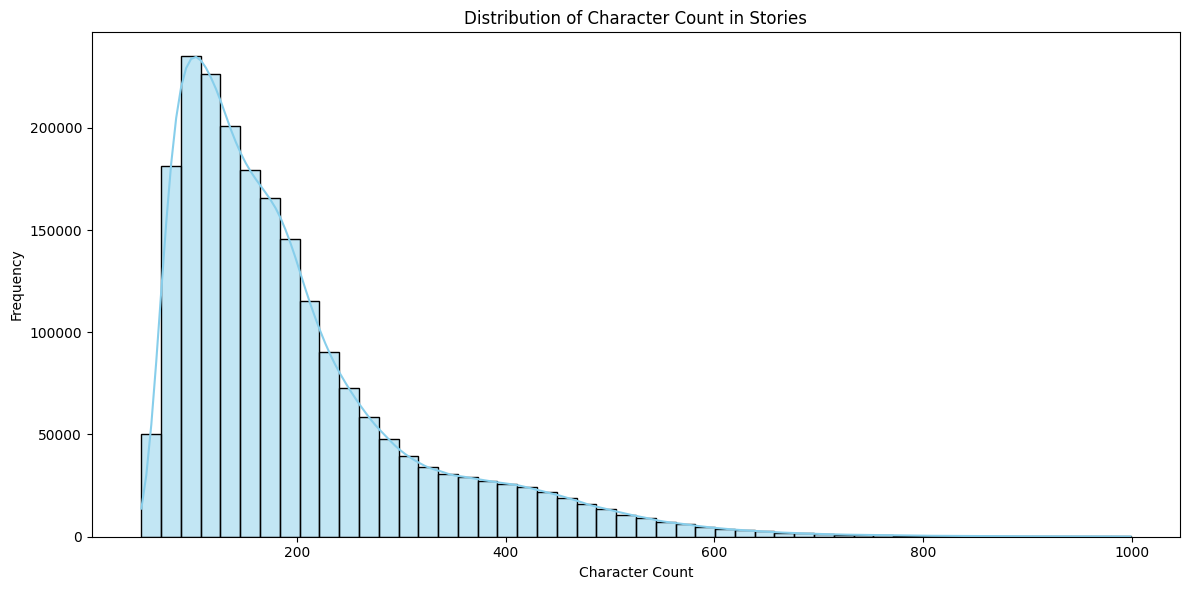

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12, 6))
sns.histplot(df['character_count'], bins=50, kde=True, color='skyblue')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.title('Distribution of Character Count in Stories')
plt.tight_layout()
plt.show()

longest_stories = df[(df["character_count"] < 1200) & (~df["story"].str.endswith("。"))].sort_values('character_count', ascending=True)

print("The ten longest stories (by character count):\n")
for idx, row in longest_stories.iterrows():
    print("--------------------------------------------------")
    print(f"Index: {idx} | Character Count: {row['character_count']}")
    print(row['story'])
    print("--------------------------------------------------\n")


In [91]:
# 3.2: Optionally upload to HF, for which you need to login with !huggingface-cli login
from datasets import Dataset

dataset = Dataset.from_pandas(df)

In [93]:
dataset = dataset.train_test_split(test_size=0.01, seed=42)

In [95]:
dataset.push_to_hub("lennart-finke/SimpleStories-" + LANGUAGE)

Uploading the dataset shards: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/lennart-finke/SimpleStories-JA/commit/af7df1efa09d7ce62fe847d987bf7f323b848935', commit_message='Upload dataset', commit_description='', oid='af7df1efa09d7ce62fe847d987bf7f323b848935', pr_url=None, pr_revision=None, pr_num=None)

4. Proceed to either analyse_dataset.ipynb or embeddings.ipynb